In [1]:
from text2brick.dataset import LegoDatasetGenerator
from text2brick.gym import IoUValidityRewardFunc
reward_function = IoUValidityRewardFunc()
NUM_SAMPLES = 20
generator = LegoDatasetGenerator(reward_function=reward_function, num_samples=NUM_SAMPLES)

In [2]:
generator.generate_dataset()

Init Memmap


Generating dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generating dataset:   5%|▌         | 1/20 [00:00<00:01,  9.95it/s]

Generating sample 0 from MNIST index 0
Skipping sample 0 due to insufficient nodes.
Generating sample 0 from MNIST index 1
Generating sample 1 from MNIST index 2
Skipping sample 2 due to insufficient nodes.
Generating sample 1 from MNIST index 3
Generating sample 2 from MNIST index 4


Generating dataset:  25%|██▌       | 5/20 [00:00<00:01, 14.95it/s]

Generating sample 3 from MNIST index 5
Generating sample 4 from MNIST index 6
Generating sample 5 from MNIST index 7
Skipping sample 7 due to insufficient nodes.
Generating sample 5 from MNIST index 8
Skipping sample 8 due to insufficient nodes.
Generating sample 5 from MNIST index 9
Generating sample 6 from MNIST index 10


Generating dataset:  45%|████▌     | 9/20 [00:00<00:00, 14.61it/s]

Generating sample 7 from MNIST index 11
Skipping sample 11 due to insufficient nodes.
Generating sample 7 from MNIST index 12
Generating sample 8 from MNIST index 13
Generating sample 9 from MNIST index 14
Skipping sample 14 due to insufficient nodes.
Generating sample 9 from MNIST index 15


Generating dataset:  55%|█████▌    | 11/20 [00:00<00:00, 15.60it/s]

Generating sample 10 from MNIST index 16
Generating sample 11 from MNIST index 17
Generating sample 12 from MNIST index 18


Generating dataset:  65%|██████▌   | 13/20 [00:00<00:00, 16.22it/s]

Generating sample 13 from MNIST index 19


Generating dataset:  75%|███████▌  | 15/20 [00:00<00:00, 16.03it/s]

Generating sample 14 from MNIST index 20
Generating sample 15 from MNIST index 21
Generating sample 16 from MNIST index 22


Generating dataset:  95%|█████████▌| 19/20 [00:01<00:00, 16.38it/s]

Generating sample 17 from MNIST index 23
Generating sample 18 from MNIST index 24
Generating sample 19 from MNIST index 25


Generating dataset: 100%|██████████| 20/20 [00:01<00:00, 15.49it/s]


Saving Memmap Data
Done!


In [6]:
from text2brick.dataset import MNISTDataset
mnist = MNISTDataset()

In [7]:
array, _, _ = mnist.sample(sample_index=2)

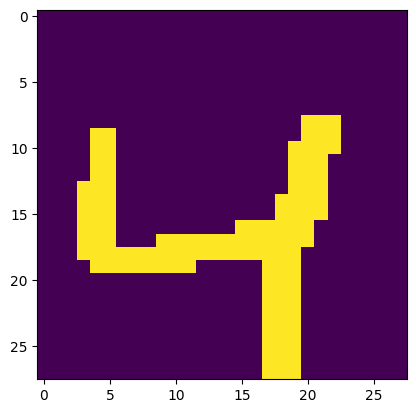

In [8]:
from matplotlib import pyplot as plt
plt.imshow(array)
plt.show()

In [5]:
from text2brick.dataset import LegoMemmapDataset
NUM_SAMPLES = 20
dataset = LegoMemmapDataset(num_graphs=NUM_SAMPLES)

In [2]:
dataset.data_memmap.shape 

(20, 5677504)

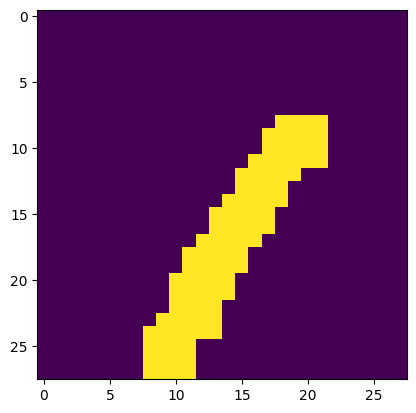

In [9]:
import matplotlib.pyplot as plt

item = dataset.__getitem__(200)

plt.imshow(item[0])
plt.show()

In [6]:
item[4].edge_index

tensor([[ 0,  1,  2,  3,  4,  4,  5,  5,  6,  7,  8,  9,  9, 10, 10, 11, 11, 12,
         12, 13, 13, 14, 14, 15, 16, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 24, 24, 25, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29,
         30, 30, 31, 31, 32, 33, 33, 34, 34, 35, 35, 36, 36, 36, 37, 37, 37, 38,
         38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 44, 44,
         44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49,
         49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 53, 53, 53, 54, 54,
         54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 60, 61, 62,
         63, 64, 65, 65, 66, 66, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 71, 71,
         72, 72, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 77, 77, 78, 78, 79, 79,
         80, 80, 80, 81, 81, 82, 82, 83, 83, 83, 84, 84, 84, 84, 85, 85, 85, 86,
         86, 87, 87, 87, 88, 88, 88, 89, 89, 89, 90, 91, 91, 92, 92, 93, 94, 95],
        [ 4,  5,  9, 10,  0

In [23]:
from text2brick.models import GraphLegoWorldData
import numpy as np

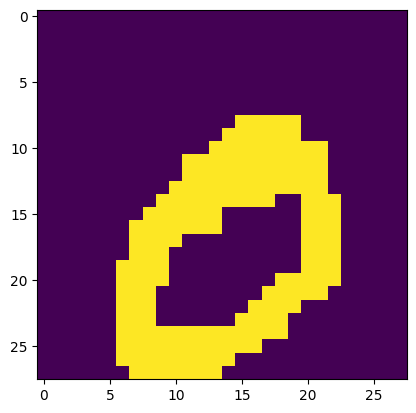

In [21]:
import matplotlib.pyplot as plt

item = dataset.__getitem__(0)

plt.imshow(item[0])
plt.show()

In [24]:
graph_2 = GraphLegoWorldData(item[0])

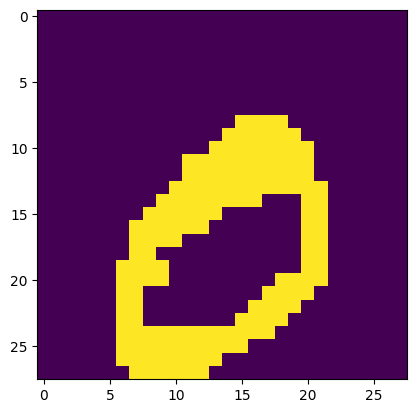

In [27]:
plt.imshow(graph_2.graph_to_table())
plt.show()

In [48]:
from torch_geometric.utils.convert import to_networkx

def convert_to_graph(tensor):
    graph_nx = to_networkx(tensor, node_attrs=['x'])

    for node, data in graph_nx.nodes(data=True):
        # Extract `x` (coordinates)
        coords = data['x']  # Convert tensor to list
        
        # Assign x and y separately for clarity
        data['x'] = int(coords[0])  # X-coordinate
        data['y'] = int(coords[1])  # Y-coordinate
    return graph_nx

In [49]:
idx = [0, 40, 120, 200, 280, 360]

In [ ]:
import matplotlib.pyplot as plt

for i in idx:
    item = dataset.__getitem__(i)
    graph = GraphLegoWorldData(item[0])
    graph_nx = convert_to_graph(graph.data)
    graph.graph = graph_nx
    plt.imshow(graph.graph_to_table())
    plt.show()

In [46]:
gph = GraphLegoWorldData(item[0])
gph.graph = graph_nx

In [36]:
graph_nx.number_of_nodes()

76

In [42]:
graph_nx.nodes(data=True)

NodeDataView({0: {'x': 7, 'y': 0}, 1: {'x': 9, 'y': 0}, 2: {'x': 11, 'y': 0}, 3: {'x': 6, 'y': 1}, 4: {'x': 8, 'y': 1}, 5: {'x': 10, 'y': 1}, 6: {'x': 12, 'y': 1}, 7: {'x': 6, 'y': 2}, 8: {'x': 8, 'y': 2}, 9: {'x': 10, 'y': 2}, 10: {'x': 12, 'y': 2}, 11: {'x': 14, 'y': 2}, 12: {'x': 6, 'y': 3}, 13: {'x': 8, 'y': 3}, 14: {'x': 10, 'y': 3}, 15: {'x': 12, 'y': 3}, 16: {'x': 14, 'y': 3}, 17: {'x': 16, 'y': 3}, 18: {'x': 6, 'y': 4}, 19: {'x': 15, 'y': 4}, 20: {'x': 17, 'y': 4}, 21: {'x': 6, 'y': 5}, 22: {'x': 16, 'y': 5}, 23: {'x': 18, 'y': 5}, 24: {'x': 6, 'y': 6}, 25: {'x': 17, 'y': 6}, 26: {'x': 19, 'y': 6}, 27: {'x': 6, 'y': 7}, 28: {'x': 8, 'y': 7}, 29: {'x': 18, 'y': 7}, 30: {'x': 20, 'y': 7}, 31: {'x': 6, 'y': 8}, 32: {'x': 8, 'y': 8}, 33: {'x': 20, 'y': 8}, 34: {'x': 7, 'y': 9}, 35: {'x': 20, 'y': 9}, 36: {'x': 7, 'y': 10}, 37: {'x': 9, 'y': 10}, 38: {'x': 20, 'y': 10}, 39: {'x': 7, 'y': 11}, 40: {'x': 9, 'y': 11}, 41: {'x': 11, 'y': 11}, 42: {'x': 20, 'y': 11}, 43: {'x': 8, 'y': 12

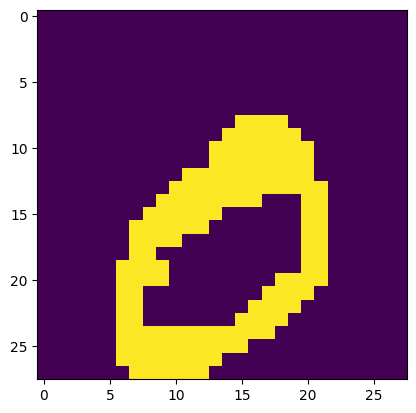

In [47]:
plt.imshow(gph.graph_to_table())
plt.show()

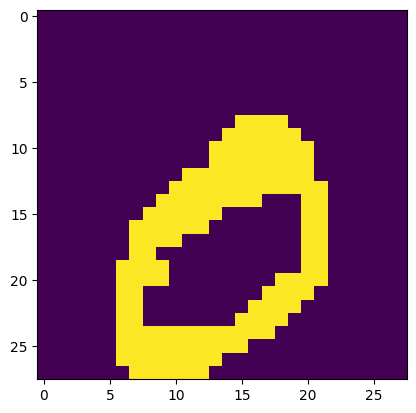

In [44]:
plt.imshow(table)
plt.show()

In [43]:
table = np.zeros((28,28), dtype=int)

# Populate the table based on the brick positions in the graph
for _, data in graph_nx.nodes(data=True):
    x, y = data['x'], data['y']
    print(x, y)
    adjusted_y = 28 - 1 - y  # Adjust 'y' so that 0 corresponds to the last row
    table[adjusted_y, x] = 1
    if x + 1 < 28:  # Check bounds to avoid index errors
        table[adjusted_y, x + 1] = 1

7 0
9 0
11 0
6 1
8 1
10 1
12 1
6 2
8 2
10 2
12 2
14 2
6 3
8 3
10 3
12 3
14 3
16 3
6 4
15 4
17 4
6 5
16 5
18 5
6 6
17 6
19 6
6 7
8 7
18 7
20 7
6 8
8 8
20 8
7 9
20 9
7 10
9 10
20 10
7 11
9 11
11 11
20 11
8 12
10 12
12 12
20 12
9 13
11 13
13 13
15 13
20 13
10 14
12 14
14 14
16 14
18 14
20 14
11 15
13 15
15 15
17 15
19 15
13 16
15 16
17 16
19 16
13 17
15 17
17 17
19 17
14 18
16 18
18 18
15 19
17 19


In [14]:
graph_3.print_graph()

Number of nodes: 25
Number of edges: 25
Node 0: {'x': 17, 'y': 0, 'saved': False, 'validity': True}
Node 1: {'x': 17, 'y': 1, 'saved': False, 'validity': True}
Node 2: {'x': 17, 'y': 2, 'saved': False, 'validity': True}
Node 3: {'x': 17, 'y': 3, 'saved': False, 'validity': True}
Node 4: {'x': 17, 'y': 4, 'saved': False, 'validity': True}
Node 5: {'x': 17, 'y': 5, 'saved': False, 'validity': True}
Node 6: {'x': 17, 'y': 6, 'saved': False, 'validity': True}
Node 7: {'x': 17, 'y': 7, 'saved': False, 'validity': True}
Node 12: {'x': 17, 'y': 8, 'saved': False, 'validity': True}
Node 20: {'x': 17, 'y': 9, 'saved': False, 'validity': True}
Node 26: {'x': 17, 'y': 10, 'saved': False, 'validity': True}
Node 27: {'x': 19, 'y': 10, 'saved': False, 'validity': True}
Node 30: {'x': 17, 'y': 11, 'saved': False, 'validity': True}
Node 31: {'x': 19, 'y': 11, 'saved': False, 'validity': True}
Node 33: {'x': 18, 'y': 12, 'saved': False, 'validity': True}
Node 34: {'x': 20, 'y': 12, 'saved': False, 'val

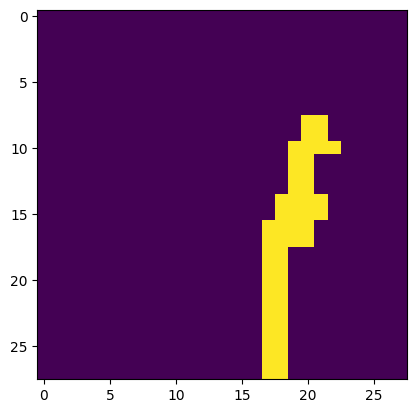

In [15]:
z = graph_3.graph_to_table()
plt.imshow(z)
plt.show()

In [16]:
graph_2.get_nodes()

NodeDataView({0: {'x': 4, 'y': 0, 'saved': False, 'validity': True}, 1: {'x': 6, 'y': 0, 'saved': False, 'validity': True}, 2: {'x': 8, 'y': 0, 'saved': False, 'validity': True}, 3: {'x': 10, 'y': 0, 'saved': False, 'validity': True}, 4: {'x': 4, 'y': 1, 'saved': False, 'validity': True}, 5: {'x': 6, 'y': 1, 'saved': False, 'validity': True}, 6: {'x': 8, 'y': 1, 'saved': False, 'validity': True}, 7: {'x': 10, 'y': 1, 'saved': False, 'validity': True}, 9: {'x': 6, 'y': 2, 'saved': False, 'validity': True}, 10: {'x': 8, 'y': 2, 'saved': False, 'validity': True}, 11: {'x': 10, 'y': 2, 'saved': False, 'validity': True}, 14: {'x': 8, 'y': 3, 'saved': False, 'validity': True}, 15: {'x': 10, 'y': 3, 'saved': False, 'validity': True}, 19: {'x': 10, 'y': 4, 'saved': False, 'validity': True}})

In [17]:
graph_2.nodes_num()

14

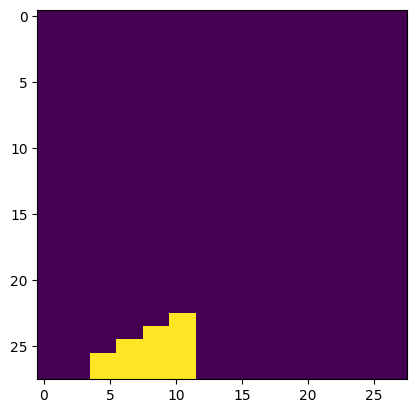

In [19]:
t = graph_2.graph_to_table()

plt.imshow(t)
plt.show()

In [37]:
from text2brick.dataset import MNISTDataset

array, _, _ = MNISTDataset().sample(sample_index=0)
graph = GraphLegoWorldData(array)

In [42]:
len(graph.get_nodes())

87

In [33]:
from torch_geometric.utils.convert import from_networkx, to_networkx

graph_nx = to_networkx(item[4], node_attrs=['x'])

for node, data in graph_nx.nodes(data=True):
    # Extract `x` (coordinates)
    coords = data['x']  # Convert tensor to list
    
    # Assign x and y separately for clarity
    data['x'] = coords[0]  # X-coordinate
    data['y'] = coords[1]  # Y-coordinate

In [41]:
len(graph_nx.nodes(data=True))

96

In [ ]:
def graph_to_table(self) -> np.ndarray:
    """
    Converts the graph representation of the LEGO world back into a 2D table.
    Each brick (node) is represented by '1's in the table.

    Returns:
        np.ndarray: A 2D array where '1' represents part of a brick and '0' represents empty space.
    """
    table = np.zeros((self.world_dim[0], self.world_dim[1]), dtype=int)
    if self._is_graph_empty():
        return table

    # Populate the table based on the brick positions in the graph
    for _, data in self.graph.nodes(data=True):
        x, y = data['x'], data['y']
        adjusted_y = self.world_dim[0] - 1 - y  # Adjust 'y' so that 0 corresponds to the last row
        table[adjusted_y, x] = 1
        if x + 1 < self.world_dim[1]:  # Check bounds to avoid index errors
            table[adjusted_y, x + 1] = 1

    return table

In [14]:
item.num_nodes

50

In [1]:
from text2brick.dataset import LegoPretrainDataset
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import torch

BATCH_SIZE = 500

dataset = LegoPretrainDataset("./lego_dataset")

train_size = int(0.9 * len(dataset))  # 90% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=8)

  0%|          | 0/1001 [00:00<?, ?it/s]c:\Users\Ewen BERNARD\Documents\GitHub\Text2Bricks\text2brick\dataset\LegoDataset.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [5]:
item = dataset.__getitem__(0)

In [9]:
item[4].edge_index.shape

torch.Size([2, 82])

In [10]:
item[4].x.shape

torch.Size([36, 2])

In [4]:
import time 
start_time = time.time()

# Fetch one batch
for i, batch in enumerate(test_loader):
    end_time = time.time()
    print(f"Time to load batch {i + 1}: {end_time - start_time:.4f} seconds")
    
    # Break after first batch if you only want to test one batch
    if i == 0:
        break

TypeError: cannot pickle '_thread.lock' object

In [2]:
first_batch = next(iter(train_loader))
print(first_batch)

TypeError: tuple indices must be integers or slices, not str

In [5]:
c = 0
for i, batch in enumerate(train_loader):
    #print(batch[4].batch)

    if batch[4].batch.max() < BATCH_SIZE - 1:
        c += 1
        print("Error count: ", c)
        
        print(i)
        print(batch[4].batch)
        print(batch[4].edge_index)
        print(batch[4].x)
print(i)

c:\Users\Ewen BERNARD\Documents\GitHub\Text2Bricks\text2brick\dataset\LegoDataset.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  """


KeyboardInterrupt: 

In [7]:
print(dataset.__getitem__(85))

Loading samples:   0%|          | 2/3193 [00:36<16:55:44, 19.10s/it]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [7]:
from text2brick.gym import Text2Brick_v1
model = Text2Brick_v1()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Ewen BERNARD/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\Ewen BERNARD/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 13.1MB/s]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cpu


Text2Brick_v1(
  (snn): SNN(
    (cnn): CNN(
      (model): Sequential(
        (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        (3): Fire(
          (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
          (squeeze_activation): ReLU(inplace=True)
          (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (expand1x1_activation): ReLU(inplace=True)
          (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (expand3x3_activation): ReLU(inplace=True)
        )
        (4): Fire(
          (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
          (squeeze_activation): ReLU(inplace=True)
          (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (expand1x1_activation): ReLU(inplace=True)
          (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), st

In [12]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the loss function (CrossEntropyLoss for classification tasks)
x_loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
y_loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, dataloader, optimizer, x_loss_fn, y_loss_fn, num_epochs=10):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        # Loop over the batches of data
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            print("loaded")
            optimizer.zero_grad()  # Zero the parameter gradients

            image_target = batch[0].to(device)
            current_build_img = batch[1].to(device)
            next_node = batch[2].to(device)
            reward = batch[3].to(device)
            current_graph = batch[4].to(device)
            
            x_pred, y_pred = model(current_build_img, current_graph, reward, image_target=image_target, return_logits=True)
            x_true, y_true = next_node[:, 0], next_node[:, 1]

            # Compute loss for both x and y coordinates
            x_loss = x_loss_fn(x_pred, x_true)
            y_loss = y_loss_fn(y_pred, y_true)

            # Combine the losses (you can weight them differently if needed)
            loss = x_loss + y_loss
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print epoch loss
        #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Run the training loop
train_model(model, train_loader, optimizer, x_loss_fn, y_loss_fn, num_epochs=10)


Epoch 1/10:   0%|          | 0/15 [00:00<?, ?it/s]

loaded


Epoch 1/10:   7%|▋         | 1/15 [00:15<03:38, 15.60s/it]

loaded


Epoch 1/10:  13%|█▎        | 2/15 [00:30<03:20, 15.42s/it]

loaded


Epoch 1/10:  20%|██        | 3/15 [00:45<02:58, 14.91s/it]

loaded


Epoch 1/10:  27%|██▋       | 4/15 [00:59<02:39, 14.50s/it]

loaded


Epoch 1/10:  33%|███▎      | 5/15 [01:14<02:29, 14.96s/it]


KeyboardInterrupt: 

In [7]:
from text2brick.gym import LegoEnv
from text2brick.dataset import MNISTDataset
import torch
from text2brick.dataset import PreprocessImage

preprocess = PreprocessImage()

dataset = MNISTDataset()

# Target
array, image, _, _ = dataset.sample(1)

env = LegoEnv((array.shape[0], array.shape[1]))

reward = torch.tensor([0], dtype=torch.float32).unsqueeze(1)
current_build_img = env.obs_as_tensor()
current_graph = env.obs_as_graph()
target_image_tensor = preprocess(image)

model.eval()

print(f"Reward size: {reward.size()}")
print(f"Current build image size: {current_build_img.size()}")
print(f"Current graph size: {current_graph.size()}")
print(f"Target image size: {target_image_tensor.size()}")

# done = False
# while not done:
#     with torch.no_grad():
#         action = model(current_build_img, current_graph, reward, image_target=target_image_tensor, return_logits=False)
#     env.step(tuple(action.tolist()), max_step = 70,  target_image=array)




[MemorizedFunc(func=<function fetch_openml at 0x000001FD0143C670>, location=./tmp\joblib)]: Exception while loading results for fetch_openml('mnist_784', version=1)
 Traceback (most recent call last):
  File "C:\Users\gourd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\memory.py", line 514, in _cached_call
    output = self._load_item(call_id)
  File "C:\Users\gourd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\memory.py", line 848, in _load_item
    return self.store_backend.load_item(call_id, metadata=metadata,
  File "C:\Users\gourd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\_store_backends.py", line 185, in load_item
    item = numpy_pickle.load(f)
  File "C:\Users\gourd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.1

________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml('mnist_784', version=1)


KeyboardInterrupt: 